In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


import PIL.Image as Image
import pandas as pd
import numpy as np

from tqdm import tqdm
import os
import glob

In [2]:
BUFFER = 64
Z_DIM = 20   # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 20  # Offset of slices in the z direction
SHARED_HEIGHT = 4096  # Height to resize all papyrii
path = "/kaggle/input/vesuvius-challenge-ink-detection/"

In [3]:
#unet model
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), padding=1):
        super(ConvBlock,self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=False)
        self.batchnorm = nn.BatchNorm2d(out_channels, eps=1e-4)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x
        
        
class StackEncoder(nn.Module):
    def __init__(self, channel1, channel2, kernel_size=(3,3), padding=1):
        super(StackEncoder,self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.block = nn.Sequential(
            ConvBlock(channel1, channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),     
        )
        
    def forward(self,x):
        big_out = self.block(x)
        poolout = self.maxpool(big_out)
        return big_out,poolout
    
class StackDecoder(nn.Module):
    def __init__(self,big_channel, channel1, channel2, kernel_size=(3,3), padding=1):
        super(StackDecoder,self).__init__()
        self.block = nn.Sequential(
            ConvBlock(channel1+big_channel,channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),
            ConvBlock(channel2, channel2, kernel_size, padding),
        )
        
    def forward(self,x, down_tensor):
            _, channels, height, width = down_tensor.size()  
            x = F.upsample(x, size=(height, width), mode='bilinear')
            x = torch.cat([x, down_tensor], 1)  
            x = self.block(x)
            return x
        
        
class Unet(nn.Module):
    def __init__(self, channel = Z_DIM):
        super(Unet,self).__init__()
        
        
        self.down1 = StackEncoder(channel,64,kernel_size=(3,3))  
        self.down2 = StackEncoder(64,128,kernel_size=(3,3))  
        self.down3 = StackEncoder(128,256,kernel_size=(3,3))  
        self.down4 = StackEncoder(256,512,kernel_size=(3,3))  
        self.down5 = StackEncoder(512,1024,kernel_size=(3,3))  
        
        self.center = ConvBlock(1024,1024,kernel_size=(3,3),padding=1) 
        
        self.up5 = StackDecoder(1024,1024,512,kernel_size=(3,3))  
        self.up4 = StackDecoder(512,512,256,kernel_size=(3,3)) 
        self.up3 = StackDecoder(256,256,128,kernel_size=(3,3))
        self.up2 = StackDecoder(128,128,64,kernel_size=(3,3))
        self.up1 = StackDecoder(64,64,64,kernel_size=(3,3))
        self.conv = nn.Conv2d(64,1,kernel_size=(1,1),bias=True)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        down1,out = self.down1(x)  
        down2,out = self.down2(out)  
        down3,out = self.down3(out)
        down4,out = self.down4(out)
        down5,out = self.down5(out)
        
        
        out = self.center(out)
        
        up5 = self.up5(out,down5)
        up4 = self.up4(up5,down4)
        up3 = self.up3(up4,down3)
        up2 = self.up2(up3,down2)
        up1 = self.up1(up2,down1)
        
        out = self.sig(self.conv(up1))


        return out

In [4]:
model_path = "/kaggle/input/model-inference/inference/model_ep42.pth"

#loading model
model = Unet()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['state_dict'])
model.eval()

Unet(
  (down1): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(20, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (down2): StackEncoder(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (batchnorm): BatchNorm2d(128, eps=0.0001, momentum=0.1, a

In [5]:
def resize(img, SHARED_HEIGHT=SHARED_HEIGHT):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

In [6]:
#load mask
def load_mask(split, index, DATA_DIR=path):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    return torch.from_numpy(np.array(img))

In [7]:
#load stack of slices along Z dimension
def load_volume(split, index, DATA_DIR=path, Z_START=Z_START, Z_DIM=Z_DIM):
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        #65535 is the max value
        z_slice = np.array(img, dtype="float32")
        z_slices.append(torch.from_numpy(z_slice))
    return torch.stack(z_slices, dim=0)

In [8]:
def rle(predictions_map, threshold):
    flat_img = predictions_map.flatten()
    flat_img = np.where(flat_img > threshold, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [9]:
def is_in_masked_zone(location, mask):
    return mask[location[0].long(), location[1].long()]

def get_subvolume(batch_loc, volume, BUFFER = BUFFER):
    # batch_loc : [batch_size, 2]
    subvolume = list()
    for l in batch_loc:
        x = l[0]
        y = l[1]
        sv = volume[:, x - BUFFER:x + BUFFER, y - BUFFER:y + BUFFER]
        sv = sv / 65535.
        subvolume.append(sv)
    # [batch, Z_DIM, BUFFER, BUFFER]
    subvolume = torch.stack(subvolume)
    return subvolume

def compute_predictions_map(split, index, model):
    print(f"======> Load data for {split}/{index}")
    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)
    print(f"======> Volume shape: {test_volume.shape}")
    test_locations = list()
    stride = BUFFER // 2

    for x in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[2] - BUFFER, stride):
            if is_in_masked_zone([torch.tensor(x),torch.tensor(y)], test_mask):
                test_locations.append((x, y))
    print(f"======> {len(test_locations)} test locations (after filtering by mask)")

    predictions_map = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    predictions_map_counts = torch.zeros((1, 1, test_volume.shape[1], test_volume.shape[2]))
    print(f"======> Compute predictions")
    with torch.no_grad():
        bar = tqdm(test_locations)
        for loc in bar:
            subvolume = get_subvolume([loc], test_volume, BUFFER = BUFFER)
            pred = model(subvolume)
            # print(loc, (pred > 0.5).sum())
            # Here a single location may be with multiple result
            predictions_map[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += pred.cpu()
            predictions_map_counts[:, :, loc[0] - BUFFER : loc[0] + BUFFER, loc[1] - BUFFER : loc[1] + BUFFER] += 1

    # print(predictions_map_b[:,:, 2500, 1000])
    # print(predictions_map_counts[:,:, 2500, 1000])
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [10]:
TEST_DIRS = sorted(os.listdir("../input/vesuvius-challenge-ink-detection/test"))

predictions_maps = list()
for index in TEST_DIRS:
    predictions_map = compute_predictions_map(split="test", index=index, model= model)
    predictions_maps.append(predictions_map)

======> Load data for test/a


20it [00:14,  1.36it/s]


======> Volume shape: torch.Size([20, 4096, 9507])
======> 23391 test locations (after filtering by mask)
======> Compute predictions


  0%|          | 0/23391 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 23391/23391 [1:40:40<00:00,  3.87it/s]


======> Load data for test/b


20it [00:26,  1.32s/it]


======> Volume shape: torch.Size([20, 4096, 4753])
======> 9951 test locations (after filtering by mask)
======> Compute predictions


100%|██████████| 9951/9951 [43:07<00:00,  3.85it/s]  


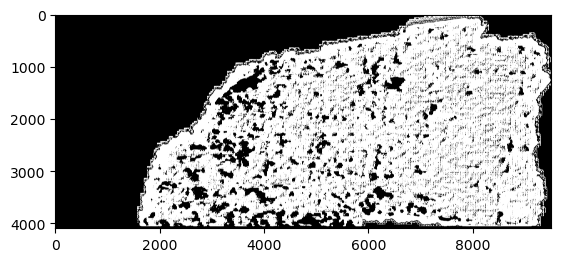

In [45]:
plt.imshow(predictions_maps[0].squeeze() > 0.002, cmap='gray')

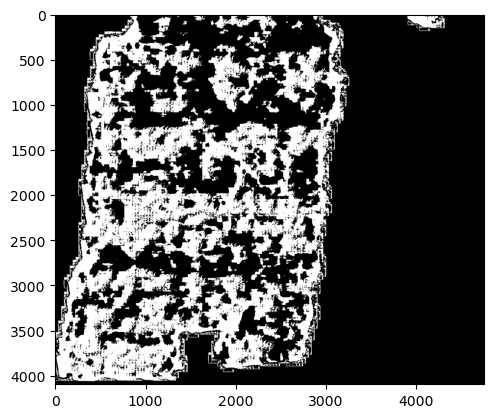

In [43]:
plt.imshow(predictions_maps[1].squeeze() > 0.0020698013, cmap='gray')

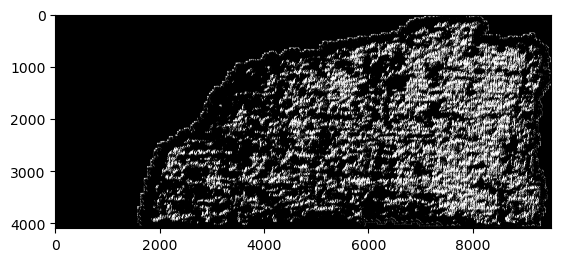

In [34]:
plt.imshow(predictions_maps[0].squeeze() > 0.0030698013, cmap='gray')

In [46]:
original_size_imgs = list()
for TEST_DIR in TEST_DIRS:
    original_size_img = Image.open(path + f"/test/{TEST_DIR}/mask.png").size
    original_size_imgs.append(original_size_img) 

In [47]:
from skimage.transform import resize as resize_ski
rescaled_predictions_maps = list()
for prediction_map, original_size_img in zip(predictions_maps, original_size_imgs):
    prediction_map = resize_ski(prediction_map.squeeze(), original_size_img).squeeze()
    rescaled_predictions_maps.append(prediction_map)

In [1]:
rles = list()
for rescaled_predictions_map in rescaled_predictions_maps:
    rle_value = rle(rescaled_predictions_map, threshold=0.0010)
    rles.append(rle_value)
    
submission = pd.DataFrame({'Id': TEST_DIRS,
                           'Predicted': rles})

submission.to_csv('../working/submission.csv', index=False)

NameError: name 'rescaled_predictions_maps' is not defined